<div align="center">
  <h1>3 - Exploratory Data Analysis</h1> <a name="0-bullet"></a>
</div>


The analysis is focused around the general characteristics of Eminem's songs (e.g., the average number of verses in a song, the number of lines in a verse, the general sentiment of a song, and similarly). In other words, the goal of the analysis is to determine what should be an "expected" output of the lyrics generators in the following notebooks (4a/b-Lyrics-Generation.ipynb), at least from the perspective of song structure. 

Therefore, the question of the analysis is: **"What does make Eminem Eminem (structurally)?"**.

The notebook is structured in four sections, including "Setup", "Song structure analysis", "Vocabulary analysis" and "Lyrics sentiment analysis".

- [1. Setup](#1-bullet)
    * [1.1 Set the working directory](#11-bullet)
    * [1.2 Load the data](#12-bullet)
    * [1.3 Missing data visualization](#13-bullet)
    * [1.4 Define helper functions](#14-bullet)
        + [1.4.1 Splitting lyrics into lines, verses and words](#141-bullet)
        + [1.4.2 Contractions and dash/hyphen words](#142-bullet) <br><br>
- [2. Song structure analysis](#2-bullet)
    * [2.1 The average number of verses, lines, words, characters and features per song](#21-bullet)
        + [2.1.1 The average number of verses per song](#211-bullet)
        + [2.1.2 The average number of lines per song](#212-bullet)
        + [2.1.3 The average number of words per song](#213-bullet)
        + [2.1.4 The average number of characters per song](#214-bullet)
        + [2.1.5 The average number of features (collaborations) per song](#215-bullet)
    * [2.2 The average length of a verse, line and word](#22-bullet)
        + [2.2.1 The average number of lines in a verse](#221-bullet)
        + [2.2.2 The average number of words in a line](#222-bullet)
        + [2.2.3 The average length of a word](#223-bullet)
    * [2.3 Summary](#23-bullet) <br><br>
- [3. Vocabulary analysis](#3-bullet)
    * [3.1 The number of unique words](#31-bullet)
    * [3.2 The average ratio of unique words per song](#32-bullet)
    * [3.3 The most frequent words](#33-bullet)
    * [3.4 Word sentiment analysis](#34-bullet)
        + [3.4.1 The average subjectivity and polarity of words](#341-bullet)
        + [3.4.2 The most frequent positive, negative and neutral words](#342-bullet)
        + [3.4.3 The most frequent words including sentiment annotation](#343-bullet)
    * [3.5 Profanity analysis](#35-bullet)
        + [3.5.1 The most common profanity words](#351-bullet)
        + [3.5.2 The relative frequency of profanity words](#352-bullet)
        + [3.5.3 The average number of profanity words per song](#353-bullet)
        + [3.5.4 S-word/F-word graph](#354-bullet)
        + [3.5.5 Profanity words through the years](#355-bullet)
    * [3.6 Word count by the first letter](#36-bullet) <br><br>
- [4. Lyrics sentiment analysis](#4-bullet)
    * [4.1 The subjectivity/polarity of lyrics](#41-bullet)
    * [4.2 The polarity of songs through the years](#42-bullet) <br><br>
- [5. Topic modeling](#5-bullet) <br>
// TODO


---

You may have to install [PyEnchant](https://pyenchant.github.io/pyenchant/index.html) and [Pickle5](https://pypi.org/project/pickle5/):
> `!pip install pyenchant` <br>
> `!pip install pickle5`

, or in Google Colab:
> `!apt install -qq enchant` <br>
> `!pip install pyenchant` <br><br>
> `!pip install pickle5`

In [1]:
import os
import re
import json
import string
import enchant
import numpy as np  
import pandas as pd
import missingno as msno
import pickle5 as pickle

from typing import Union
from collections import defaultdict

from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.patches import Patch
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mario/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


---

# 1. Setup <a name="1-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

## 1.1 Set the working directory <a name="11-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [ ]:
ROOT_DIR = "./eminem-lyrics-generator/notebooks/" 
IN_GOOGLE_COLAB = True

if IN_GOOGLE_COLAB:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'

    # create a root directory if there's none
    if not os.path.isdir(ROOT_DIR):
        %mkdir $ROOT_DIR

    # change the current working directory
    %cd $ROOT_DIR

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/eminem-lyrics-generator/notebooks


## 1.2 Load the data <a name="12-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [2]:
# specifies paths to all files in the project
SETTINGS_FILE_DIR = os.path.join(os.path.abspath(".."), "SETTINGS.json")
settings = json.load(open(SETTINGS_FILE_DIR))

In [3]:
EMINEM_DF_DIR = settings['EMINEM_DF_ALL_CLEAN_PATH']              # or 'EMINEM_DF_SONGS_CLEAN_PATH' 

with open(EMINEM_DF_DIR, 'rb') as f:
    data_df = pickle.load(f)

data_df.head()

,song_id,state,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
0,235729,complete,Rap God,Eminem,None,1,672689,The Marshall Mathers LP2 (Deluxe),2013-10-14,"[Intro] ""Look, I was gonna go easy on you not ...",https://genius.com/Eminem-rap-god-lyrics,[It’s clear now to everyone who the King and t...,459
1,3958196,complete,Killshot,Eminem,None,2,<NA>,None,2018-09-14,"[Intro] You sound like a bitch, bitch Shut the...",https://genius.com/Eminem-killshot-lyrics,"[Eminem Sucks haha, GENIUS NOT EVEN READY LOL,...",1252
2,5180439,complete,Godzilla,Eminem,[Juice WRLD],3,594809,Music to Be Murdered By,2020-01-17,"[Intro] Ugh, you're a monster [Verse 1: Emine...",https://genius.com/Eminem-godzilla-lyrics,[This definitely takes the spot of most unexpe...,624
3,207,complete,Lose Yourself,Eminem,None,4,452012,The Singles,2002-10-28,"[Intro] Look, if you had one shot or one oppor...",https://genius.com/Eminem-lose-yourself-lyrics,[This was Eminem at the top of the entire rap ...,265
4,235732,complete,The Monster,Eminem,[Rihanna],5,672689,The Marshall Mathers LP2 (Deluxe),2013-10-29,[Intro: Rihanna] I'm friends with the monster ...,https://genius.com/Eminem-the-monster-lyrics,[Why do people hate that Eminem is different n...,171


## 1.3 Missing data visualization (songs sorted by popularity) <a name="13-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

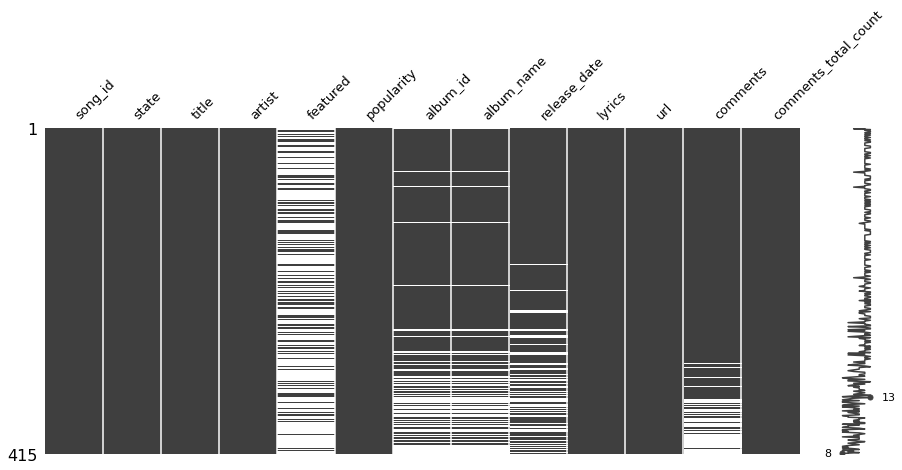

In [ ]:
# sorted by popularity
msno.matrix(data_df.sort_values('popularity', ascending=True), 
            figsize=(15,6), 
            fontsize=13)
plt.show()

Some of the columns, like "song_id", "artist", "state", "album_id", "comments", etc., are not very useful for the analysis, so they can be removed from the dataset. However, they can be still quite useful for inspecting potentially corrupted lyrics and deciding whether or not to remove them from the dataset.

In [4]:
print(data_df['state'].value_counts())

# remove the state column from the dataset
states = data_df.pop('state')

complete      415
unreleased      0
Name: state, dtype: int64


In [5]:
data_df.head()

,song_id,title,artist,featured,popularity,album_id,album_name,release_date,lyrics,url,comments,comments_total_count
0,235729,Rap God,Eminem,None,1,672689,The Marshall Mathers LP2 (Deluxe),2013-10-14,"[Intro] ""Look, I was gonna go easy on you not ...",https://genius.com/Eminem-rap-god-lyrics,[It’s clear now to everyone who the King and t...,459
1,3958196,Killshot,Eminem,None,2,<NA>,None,2018-09-14,"[Intro] You sound like a bitch, bitch Shut the...",https://genius.com/Eminem-killshot-lyrics,"[Eminem Sucks haha, GENIUS NOT EVEN READY LOL,...",1252
2,5180439,Godzilla,Eminem,[Juice WRLD],3,594809,Music to Be Murdered By,2020-01-17,"[Intro] Ugh, you're a monster [Verse 1: Emine...",https://genius.com/Eminem-godzilla-lyrics,[This definitely takes the spot of most unexpe...,624
3,207,Lose Yourself,Eminem,None,4,452012,The Singles,2002-10-28,"[Intro] Look, if you had one shot or one oppor...",https://genius.com/Eminem-lose-yourself-lyrics,[This was Eminem at the top of the entire rap ...,265
4,235732,The Monster,Eminem,[Rihanna],5,672689,The Marshall Mathers LP2 (Deluxe),2013-10-29,[Intro: Rihanna] I'm friends with the monster ...,https://genius.com/Eminem-the-monster-lyrics,[Why do people hate that Eminem is different n...,171


## 1.4 Define helper functions <a name="14-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### 1.4.1 Splitting lyrics into lines, verses and words <a name="141-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [6]:
def split_lyrics_into_lines(lyrics: str) -> list:
    """Splits lyrics into lines. The end of a line is specified with the newline character."""
    
    # remove section headers, lower all letters and split it into lines
    step1 = re.sub("\[.*\]|[\'-]", "", lyrics) \
              .lower() \
              .split('\n')
    # remove all characters except letters
    step2 = [re.sub("[^a-z]", " ", vers) for vers in step1 if vers != '']
    # remove multiple white spaces
    step3 = [re.sub("\s{2,}", " ", vers).strip() for vers in step2]

    return step3

In [7]:
def split_lyrics_into_words(lyrics: str) -> list:
    """Splits lyrics into words. Does not clean contractions or dash words."""

    # remove section headers
    step1 = re.sub("\[.*\]\n", " ", lyrics.lower())           
    # remove all characters except letters, single quotation marks and dashes
    step2 = re.sub("[^a-z\'-]", " ", step1)             # or [^a-zA-z0-9]
    # replace consecutive identical quotations and dashes with only one character
    step3 = re.sub(r"([\'-]|\s)\1{2,}", r"\1", step2)
    # filter consecutive white spaces
    step4 = re.sub(r"\s{2,}", r" ", step3).strip()
    # reduce multiple consecutive identical letters into only two letters 
    step5 = re.sub(r"([a-z])\1{2,}", r"\1\1", step4)

    return step5.split(' ')

In [8]:
SPECIAL_CASES = ['Book of Rhymes', 'Just the Two of Us']

def get_only_eminems_verses(row: pd.core.series.Series) -> str:
    "Removes section headers from the lyrics and returns only Eminem's verses."

    assert({'title', 'featured', 'lyrics'}.issubset(row.keys()))

    # clean the section headers that end with double newline characters
    lyrics = re.sub("]\n\n", "]\n", row.lyrics)

    # songs that has no features (with few exceptions)
    if row[['featured']].isnull().values or row['title'] in SPECIAL_CASES:
        return re.sub("\[.*\]\n", "", lyrics)
    
    # split lyrics into verses
    song_verses = lyrics.split('\n\n')

    em_verses = ""
    for verse in song_verses:
        # check if the verse has one of the Eminem's section headers
        if re.search("\[.*Eminem.*\]", verse) or \
           re.search("\[.*Slim Shady.*\]", verse) or \
           re.search("\[.*B-Rabbit.*\]", verse) or \
           re.search("\[.*M&M.*\]", verse):
            # append the verse to the previuos
            em_verses += re.sub("\[.*\]\n", "", verse) + '\n\n'

    return em_verses

### 1.4.2 Contractions and dash/hyphen words <a name="142-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [9]:
CONTRACTIONS_TABLE_FILE = settings['CONTRACTIONS_TABLE_PATH'] 

# load the contraction table from a text file
contractions = {}
with open(CONTRACTIONS_TABLE_FILE) as f:   
    for line in f:
        (key, val) = line.split(':')
        contractions[key] = val.strip()


def edit_contractions(word: str, contraction_table=contractions) -> str:
    """
    Expands a contraction word if the word is in the table, otherwise 
    removes everthing after the apostrophe. If the word isn't a contraction, 
    the function just returns it.
    """

    # expand from the table
    if word in contraction_table:
        return contraction_table[word]
        
    # otherwise remove everything after the apostrophe
    if "'" in word:
        return re.sub("'.*", "", word)
    
    # return the word if it isn't a contraction
    return word

In [10]:
def edit_dash_words(word: str) -> str:
    """
    A custom function for processing dash/hyphen words, specifically 
    constructed for the words in this project. If the word doesn't have 
    a dash, the function just returns it.
    """

    # return empty words
    if word == '':
        return word

    # "delete" the word if it has a dash character and the length smaller 
    # than four or more than one dash
    if ('-' in word and len(word) < 4) or len(word.split('-')) > 2:
        return ''

    # remove a dash from the end
    if word[-1] == '-':
        return word[:-1]

    # remove a dash from the second to the last position in the word
    if len(word) > 1 and word[-2] == '-':
        return word[:-2]
        
    # if a dash is in the first two characters, remove it
    if '-' in word[:2]:
        return word.split('-')[1]

    return word

In [11]:
d = enchant.Dict("en_US")

def expand_ing_contractions(words: Union[str, list]) -> list:
    """
    Expands contraction words that end with "in" suffix, by 
    adding a "g" character to the suffix.
    """

    # if the input is a string, put it in an empty list
    if type(words) != type([]):
        words = [words]

    processed = []
    for word in words:
        # check if the word ends with "in" and isn't a valid word already (like "main", "certain", etc.)
        if word.endswith('in') and not d.check(word):
            processed.append(word + 'g')
        else:
            processed.append(word)

    return processed

In [12]:
# define stopwords
ADDITIONAL_STOPWORDS = [' ', '', 'u', 'cannot']
mystopwords = stopwords.words('english') + ADDITIONAL_STOPWORDS

# init lemmatizer
lemmatizer = WordNetLemmatizer() 

def dash_and_contractions_cleaning(words: Union[str, list], mystopwords=mystopwords) -> list:
    """
    A general custom function for processing words in this project. Includes multiple 
    previously defined funcitons, like `edit_contractions`, `edit_dash_words` 
    and `expand_ing_contractions` functions. Removes english stopwords as well.
    """

    # if the input is a string, put it in an empty list
    if type(words) != type([]):
        words = [words]

    processed_words = []
    for token in words:
        if token in mystopwords or len(token) < 2:
            continue

        # lemmatizer is mainly used to process plural words,
        # this step ends with splitting the expanded word with a whitespace
        step1 = edit_contractions(edit_dash_words(lemmatizer.lemmatize(token))).split(' ')
        # remove new stopwords
        step2 = [word for word in step1 if not word in mystopwords]
        step3 = expand_ing_contractions(step2)
        
        processed_words.extend(step3)

    return processed_words if len(processed_words) != 0 else ''

---

# 2. Song structure analysis <a name="2-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [23]:
# use a special matplotlib style
style.use('fivethirtyeight')

## 2.1 The average <ins>number</ins> of verses, lines, words, characters and features per song <a name="21-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### 2.1.1 The average number of verses per song <a name="211-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

#### a) all verses

mean: 4.38
std: 3.47 



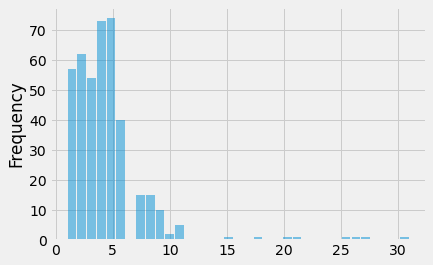

In [ ]:
# splits lyrics into verses
count_verses = lambda lyrics: len(lyrics.split('\n\n'))

# total number of verses in each song
verses_count = data_df.lyrics.apply(count_verses)

# show results
print('mean: %.2f' % verses_count.mean())
print('std: %.2f' % verses_count.std(), '\n')

verses_count.plot.hist(bins=35, rwidth=0.89, alpha=0.5)
plt.show()

#### b) unique verses

mean: 4.31
std: 3.39 



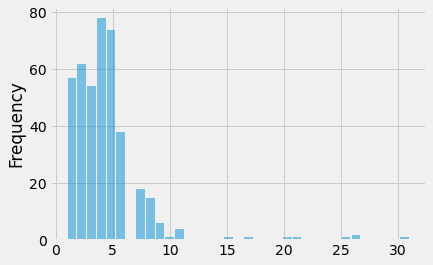

In [ ]:
# splits lyrics into verses and converts the list into a set to remove the duplicates
count_unique_verses = lambda lyrics: len(set(lyrics.split('\n\n')))

# total number of unique verses in each song
unique_verses_count = data_df.lyrics.apply(count_unique_verses)

# show results
print('mean: %.2f' % unique_verses_count.mean())
print('std: %.2f' % unique_verses_count.std(), '\n')

unique_verses_count.plot.hist(bins=35, rwidth=0.89, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 5
outliers_idxs = ( np.abs( unique_verses_count - unique_verses_count.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                unique_verses_count[outliers_idxs]], 
          axis=1) \
  .rename(columns={'lyrics':'verses'})

,title,artist,featured,release_date,verses
320,First Word Freestyle,Eminem,None,NaT,31
364,MC Hammer vs. Vanilla Ice,Eminem,[Proof],1990-01-01,26
340,2004 Tim Westwood Freestyle,Eminem,"[Stat Quo, Tim Westwood, D12]",NaT,26
241,Dr. West (Skit),Eminem,[Dominic West],2009-05-15,25
304,Just Rhymin’ with Proof,Eminem,[Proof],2000-12-01,21


### 2.1.2 The average number of lines per song <a name="212-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

#### a) all lines

mean: 78.34
std: 54.28 



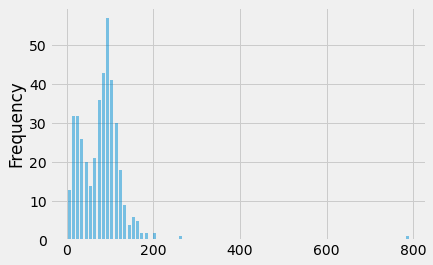

In [ ]:
# total number of lines in each song
lines_count = data_df.lyrics.apply(lambda lyrics: len(split_lyrics_into_lines(lyrics)))

# show results
print('mean: %.2f' % lines_count.mean())
print('std: %.2f' % lines_count.std(), '\n')

lines_count.plot.hist(bins=80, rwidth=0.7, alpha=0.5)
plt.show()

#### b) unique lines

mean: 67.99
std: 51.07 



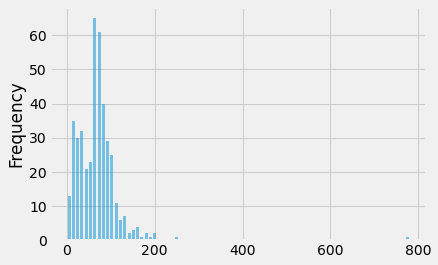

In [ ]:
# total number of unique lines in each song
unique_lines_count = data_df.lyrics.apply(lambda lyrics: len(set(split_lyrics_into_lines(lyrics))))

# show results
print('mean: %.2f' % unique_lines_count.mean())
print('std: %.2f' % unique_lines_count.std(), '\n')

unique_lines_count.plot.hist(bins=80, rwidth=0.7, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 5
outliers_idxs = ( np.abs( unique_lines_count - unique_lines_count.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                unique_lines_count[outliers_idxs]], 
          axis=1) \
  .rename(columns={'lyrics':'lines'})

,title,artist,featured,release_date,lines
340,2004 Tim Westwood Freestyle,Eminem,"[Stat Quo, Tim Westwood, D12]",NaT,781
121,Eminem Freestyles on Tim Westwood | 2009,Eminem,[​dEnAun],2009-05-27,246
190,Kick Off (Freestyle),Eminem,None,2018-11-30,202
334,Baruch College Session,Eminem,None,1997-01-01,202
56,Campaign Speech,Eminem,None,2016-10-19,187


### 2.1.3 The average number of words per song <a name="213-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

#### a) all words

mean: 675.10
std: 403.67 



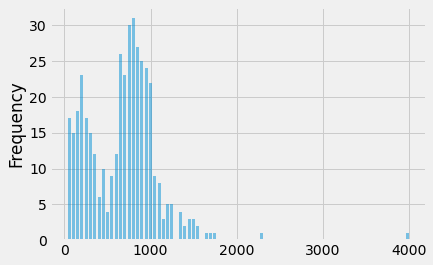

In [ ]:
# total number of words in each song
words_count = data_df.lyrics.apply(lambda lyrics: len(split_lyrics_into_words(lyrics)))

# show results
print('mean: %.2f' % words_count.mean())
print('std: %.2f' % words_count.std(), '\n')

words_count.plot.hist(bins=80, rwidth=0.7, alpha=0.5)
plt.show()

#### b) unique words

mean: 283.57
std: 148.14 



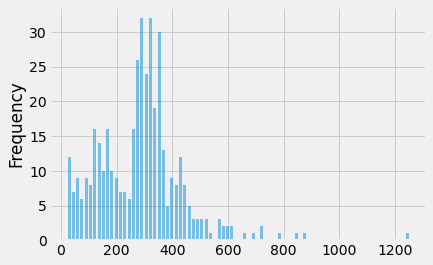

In [ ]:
# total number of unique words in each song
unique_words_count = data_df.lyrics.apply(lambda lyrics: len(set(split_lyrics_into_words(lyrics))))

# show results
print('mean: %.2f' % unique_words_count.mean())
print('std: %.2f' % unique_words_count.std(), '\n')

unique_words_count.plot.hist(bins=80, rwidth=0.7, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 6
outliers_idxs = ( np.abs( unique_words_count - unique_words_count.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                unique_words_count[outliers_idxs]], 
          axis=1) \
  .rename(columns={'lyrics':'words'})

,title,artist,featured,release_date,words
340,2004 Tim Westwood Freestyle,Eminem,"[Stat Quo, Tim Westwood, D12]",NaT,1253
121,Eminem Freestyles on Tim Westwood | 2009,Eminem,[​dEnAun],2009-05-27,870
190,Kick Off (Freestyle),Eminem,None,2018-11-30,843
56,Campaign Speech,Eminem,None,2016-10-19,782
277,Em360 Rapcity Backroom Freestyle,Eminem,"[Big Tigger, Slaughterhouse]",2013-11-06,729
334,Baruch College Session,Eminem,None,1997-01-01,719


### 2.1.4 The average number of characters per song <a name="214-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

mean: 3569.95
std: 2107.28 



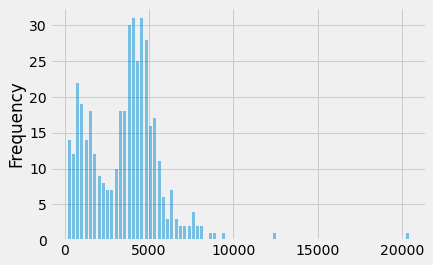

In [ ]:
# total number of chars in each song
chars_count = data_df.lyrics.apply(lambda lyrics: len(lyrics))

# show results
print('mean: %.2f' % chars_count.mean())
print('std: %.2f' % chars_count.std(), '\n')

chars_count.plot.hist(bins=80, rwidth=0.7, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 6
outliers_idxs = ( np.abs( chars_count - chars_count.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                chars_count[outliers_idxs]], 
          axis=1) \
  .rename(columns={'lyrics':'chars'})

,title,artist,featured,release_date,chars
340,2004 Tim Westwood Freestyle,Eminem,"[Stat Quo, Tim Westwood, D12]",NaT,20444
121,Eminem Freestyles on Tim Westwood | 2009,Eminem,[​dEnAun],2009-05-27,12544
190,Kick Off (Freestyle),Eminem,None,2018-11-30,9484
277,Em360 Rapcity Backroom Freestyle,Eminem,"[Big Tigger, Slaughterhouse]",2013-11-06,8872
334,Baruch College Session,Eminem,None,1997-01-01,8604
56,Campaign Speech,Eminem,None,2016-10-19,8156


### 2.1.5 The average number of features (collaborations) per song <a name="215-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

mean: 0.44
std: 0.81 



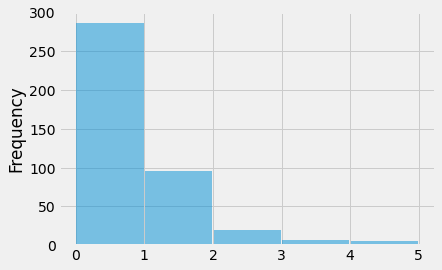

In [ ]:
# number of featured artists in each song
features_count = data_df.featured.apply(lambda featured: 0 if featured is None else len(featured))

# show results
print('mean: %.2f' % features_count.mean())
print('std: %.2f' % features_count.std(), '\n')

features_count.plot.hist(bins=5, rwidth=0.98, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 6
outliers_idxs = ( np.abs( features_count - features_count.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                features_count[outliers_idxs]], 
          axis=1) 

,title,artist,featured,release_date,featured
174,My Syllables,Eminem,"[JAY-Z, Dr. Dre, 50 Cent, Stat Quo, Ca$his]",NaT,5
46,Detroit vs. Everybody,Eminem,"[Danny Brown, Trick Trick, Royce da 5'9"", DeJ ...",2014-11-11,5
99,Yah Yah,Eminem,"[Royce da 5'9"", Black Thought, Q-Tip, ​dEnAun]",2020-01-17,4
290,We’re Back,Eminem,"[Obie Trice, Stat Quo, Bobby Creekwater, Ca$his]",2006-12-05,4
82,Bitch Please II,Eminem,"[Dr. Dre, Snoop Dogg, Nate Dogg, Xzibit]",2000-05-23,4
218,8 Mile: 313 Cypher (Chin Tiki Girls),Eminem,"[Omar Benson Miller, Mekhi Phifer, Obie Trice,...",2002-11-09,4


## 2.2 The average <ins>length</ins> of a verse, line and word <a name="22-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### 2.2.1 The average number of lines in a verse <a name="221-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [ ]:
def get_avg_verse_length(lyrics):
    """Calculates the average length of verses in `lyrics`."""

    # remove section headers and split lyrics into verses
    verses = re.sub("\[.*\]\n", "", lyrics).split('\n\n')
    # calculate the length for each verse in the lyrics
    verses_lenghts = [len(verse.split('\n')) for verse in verses]
    # return the average length of verses
    return np.mean(verses_lenghts)

mean: 22.06
std: 16.00 



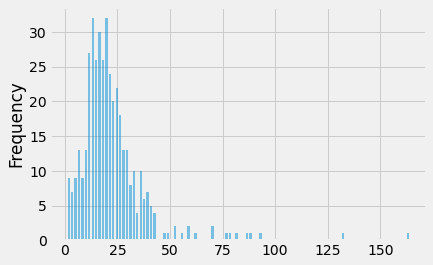

In [ ]:
# average number of lines in verses per song
avg_len_of_verse = data_df.lyrics.apply(get_avg_verse_length)

# show results
print('mean: %.2f' % avg_len_of_verse.mean())
print('std: %.2f' % avg_len_of_verse.std(), '\n')

avg_len_of_verse.plot.hist(bins=100, rwidth=0.70, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 6
outliers_idxs = ( np.abs( avg_len_of_verse - avg_len_of_verse.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                avg_len_of_verse[outliers_idxs]], 
          axis=1)  \
  .rename(columns={'lyrics':'lines per verse'})

,title,artist,featured,release_date,lines per verse
46,Detroit vs. Everybody,Eminem,"[Danny Brown, Trick Trick, Royce da 5'9"", DeJ ...",2014-11-11,164.0
100,Still Shady,Eminem,None,2014-11-24,132.0
56,Campaign Speech,Eminem,None,2016-10-19,93.5
86,Arose,Eminem,None,2017-12-15,89.0
102,Castle,Eminem,None,2017-12-15,87.0
19,Bad Guy,Eminem,None,2013-11-05,82.0


### 2.2.2 The average number of words in a line  <a name="222-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

mean: 9.00
std: 5.67 



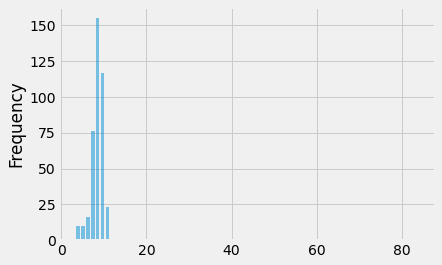

In [ ]:
# average number of words in a line per song
avg_len_of_line = data_df.lyrics.apply(lambda lyrics: np.mean([len(line.split(' ')) for line in split_lyrics_into_lines(lyrics)]))

# show results
print('mean: %.2f' % avg_len_of_line.mean())
print('std: %.2f' % avg_len_of_line.std(), '\n')

avg_len_of_line.plot.hist(bins=70, rwidth=0.70, alpha=0.5)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 5
outliers_idxs = ( np.abs( avg_len_of_line - avg_len_of_line.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                avg_len_of_line[outliers_idxs]], 
          axis=1)  \
  .rename(columns={'lyrics':'words per line'})

,title,artist,featured,release_date,words per line
412,Fuck Obie (Skit),Eminem,None,2006-08-12,10.538462
348,Power 92.3 Freestyle,Eminem,None,NaT,7.878788
309,1-833-2GET-REV (REVIVAL Voicemail),Eminem,None,2017-10-25,61.000000
409,Whoo Kid Freestyle,Eminem,None,NaT,8.419355
310,Curtains Up (Skit) [2004],Eminem,None,2004-11-12,3.384615


### 2.2.3 The average length of a word (not cleaned) <a name="223-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

mean: 4.00
std: 2.05 



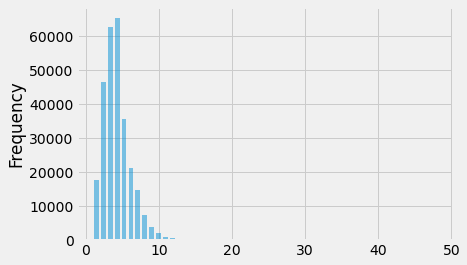

In [25]:
# get length of each word in the corpus
all_words = np.concatenate(data_df.lyrics.apply(split_lyrics_into_words))
all_words_len = np.vectorize(len)(all_words)

# show results
print('mean: %.2f' % np.mean(all_words_len))
print('std: %.2f' % np.std(all_words_len), '\n')

pd.DataFrame(all_words_len).plot.hist(bins=50, rwidth=0.70, alpha=0.5, legend=False)
plt.show()

#### > show outliers

In [ ]:
# find outliers
N_TOP = 130
outliers_idxs = ( np.abs( all_words_len - np.mean(all_words_len) ) ).argsort()[-N_TOP:][::-1]

# get outlier words
outlier_words = all_words[outliers_idxs]
# filter dash/hyphen words
no_dash_outlier_words_idxs = np.vectorize(lambda word: not '-' in word)(outlier_words)

# show results
words_len_df = pd.DataFrame([all_words, all_words_len], index=['word', 'length']).T
words_len_df.iloc[outliers_idxs][no_dash_outlier_words_idxs] \
            .drop_duplicates() \
            .reset_index(drop=True)

,word,length
0,antidisestablishmentarianism,28
1,pooaaooaaooaaooaaooaooassee,27
2,sensitivitytoothpaintight,25
3,fingernailsdramatically,23
4,hahahahahahahahahahaha,22
5,balalalalalalalalalala,22
6,achecoughshortness,18
7,womenragedecreased,18
8,appetiteincreased,17
9,responsibilities,16


## 2.3 Summary <a name="23-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

**I.** The average **NUMBER** of:
- **VERSES** per song: 
    - *all verses*:
        - mean: **4.38**
        - std: **3.47**
    - *unique verses*: 
        - mean: **4.31**
        - std: **3.39**
- **LINES** per song:
    - *all lines*:
        - mean: **78.34**
        - std: **54.28**
    - *unique lines*:
        - mean: **67.99**
        - std: **51.07**
- **WORDS** per song:
    - *all words*:
        - mean: **675.10**
        - std: **403.67**
    - *unique words*:
        - mean: **283.57**
        - std: **148.44**
        
        
- **CHARACTERS** per song:
    - mean: **3569.95**
    - std: **2107.8**
- **FEATURES** per song:
    - mean: **0.44**
    - std: **0.81** <br><br>
    
    
**II.** The average **LENGTH** of:
- **VERSE** (in lines):
    - mean: **22.06**
    - std: **16.00**
- **LINE** (in words):
    - mean: **9.00**
    - std: **5.67**
- **WORD**:
    - mean: **4.00**
    - std: **2.05**


---

# 3. Vocabulary analysis <a name="3-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [13]:
# use a special matplotlib style
style.use('fivethirtyeight')

# get only Eminem's verses from each song
em_verses = data_df.apply(get_only_eminems_verses, axis=1)

## 3.1 The number of unique words <a name="31-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

This could be seen as Eminem's vocabulary. However, the number obtained in this analysis should be probably somewhat smaller, mostly becuase it includes various interjection sounds (like "agh", "uh", "haha"), different verb tenses, words from unpublished songs and freestyles, people's names, misspelled words, etc., all recognized as unique words. 

**The reference number**: <br>
The size of Eminem's vocabulary measured in [this](https://www.billboard.com/articles/columns/the-juice/6642050/eminem-largest-vocabulary-music-industry) article (**8,818 words - 24/07/2015**) can be used for the comparison of obtained results, mostly to see how close or off is the analysis.

### a) Total words said

In [ ]:
all_words = np.concatenate(em_verses.apply(split_lyrics_into_words).apply(dash_and_contractions_cleaning))
len(all_words)

123994

### b) Unique words said

In [ ]:
len(set(all_words))

13320

As expected, there is a lot more words than mentioned in the article, but still this should be in the acceptable range, especially considering six years (2015-2021) of difference between the two.

Still, just to see how many new words Eminem has added to his vocabulary in the last six years (according to this dataset, and with some gibberish words included as well), the following analysis is performed.

In [ ]:
# get words from the songs before 2015, including the songs with no release date (mostly his earlier 
# unpublished songs and freestyles)
RESEARCH_DATE = '2015-06-1'       
all_words_before_2015 =  data_df[(data_df.release_date <= RESEARCH_DATE) | (data_df.release_date.isnull())] \
                            .apply(get_only_eminems_verses, axis=1) \
                            .apply(split_lyrics_into_words) \
                            .apply(dash_and_contractions_cleaning)

# create one list with all words (including duplicates)
all_words_before_2015 = np.concatenate(all_words_before_2015.values)

# number of unique words before 2015
len(set(all_words_before_2015))

11174

which differs by... from the number mentioned in the article.

In [ ]:
len(set(all_words_before_2015)) - 8818

2356

And the number of new unique words after 2015 is...

In [ ]:
len(set(all_words)) - len(set(all_words_before_2015))

2146

## 3.2 The average ratio of unique words per song <a name="32-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

Calculating the average ratio of unique words in lyrics, including each song in the corpus.

The equation used to calculate the ratio is as follows:

$$ UWR\ (lyrics)\ =\text{ ... }\ = \frac{N_\text{unique words}}{N_\text{all words}},\qquad UWR\ =\text{unique words ratio}$$

, where *N* is the number of words in the lyrics.

mean: 0.68
std: 0.13 



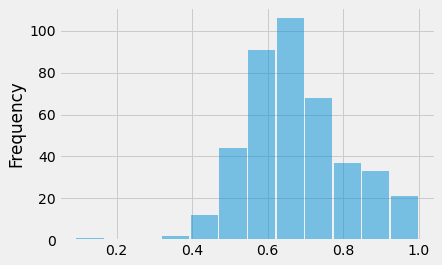

In [ ]:
# calculate the unique words ratio (not including stopwords) for each song 
unique_words_ratio = data_df.apply(get_only_eminems_verses, axis=1) \
                            .apply(split_lyrics_into_words) \
                            .apply(dash_and_contractions_cleaning) \
                            .apply(lambda words: len(set(words)) / len(words)) \
    
# show results
print('mean: %.2f' % unique_words_ratio.mean())
print('std: %.2f' % unique_words_ratio.std(), '\n')

unique_words_ratio.plot.hist(bins=12, rwidth=0.95, alpha=0.5)
plt.show()

In [ ]:
# find outliers
N_TOP = 10
outliers_idxs = ( np.abs( unique_words_ratio - unique_words_ratio.mean() ) ).argsort()[-N_TOP:][::-1]

# show results
pd.concat(objs=[data_df.iloc[outliers_idxs][['title', 'artist', 'featured', 'release_date']], 
                unique_words_ratio[outliers_idxs]], 
          axis=1)  \
  .rename(columns={0 :'unique words ratio'})

,title,artist,featured,release_date,unique words ratio
326,My Salsa,Eminem,None,2004-03-14,0.091837
292,Alfred (Intro),Eminem,None,2020-12-18,1.000000
246,Alfred (Outro),Eminem,None,2020-01-17,1.000000
255,Public Service Announcement,Eminem,[Jeff Bass],1999-02-23,1.000000
285,Steve Berman (Skit) [2002],Eminem,[Steve Berman],2002-05-26,1.000000
32,Superman,Eminem,[Dina Rae],2002-05-26,0.380855
321,1998 Wake Up Show Freestyle,Eminem,None,NaT,0.971154
76,FACK,Eminem,None,2005-12-06,0.389078
298,It’s Only Fair to Warn [Freestyle],Eminem,None,2010-01-01,0.964286
352,’97 Blazer,Eminem,None,NaT,0.952703


## 3.3 The most frequent words <a name="33-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [15]:
# count word frequencies
word_counts_df = pd.DataFrame(all_words)[0].value_counts()

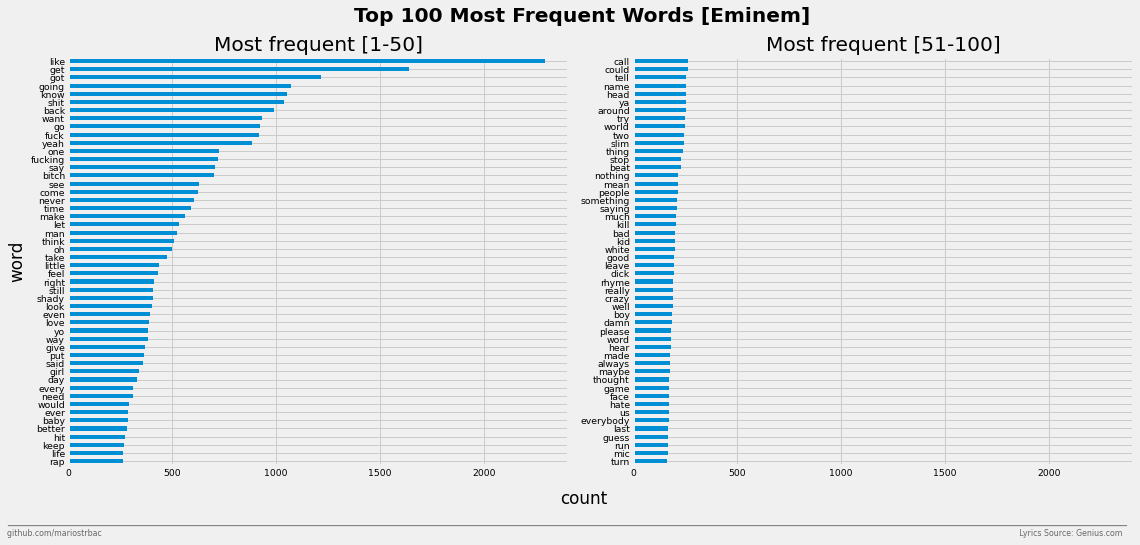

In [17]:
style.use('fivethirtyeight')

# words per subplot
NUM_OF_WORDS = 50

fig, axs = plt.subplots(1, 2, figsize=(17,7), sharex=True)

# left subplot [1-50]
word_counts_df[:NUM_OF_WORDS].plot(kind='barh',
                                   title="Most frequent [1-50]",
                                   ylabel='word',
                                   fontsize=9.3,
                                   ax=axs[0]).invert_yaxis()

# right subplot [51-100]
word_counts_df[NUM_OF_WORDS:2*NUM_OF_WORDS].plot(kind='barh',
                                                 title="Most frequent [51-100]",
                                                 ylabel='',
                                                 fontsize=9.3,
                                                 ax=axs[1]).invert_yaxis()
# title
fig.text(x=0.5, y=0.95, s='Top 100 Most Frequent Words [Eminem]', ha='center', fontsize='x-large', fontweight=555)
# x-label
plt.xlabel("count", x=-0.1, y=0.042, labelpad=12)
# signature bar
fig.text(x=0.03, y=-0.045, s=str('_'*160).expandtabs(), color='grey')
fig.text(x=0.03, y=-0.07, 
         s=str("github.com/mariostrbac " + "  " * 183 + "Lyrics Source: Genius.com").expandtabs(),
         fontsize=7.9,
         color='dimgrey')

plt.subplots_adjust(wspace=0.13, hspace=0)
plt.savefig("../reports/figures/vocabulary-analysis/100_most_frequent_words.png", dpi=200, bbox_inches='tight')
plt.show()

## 3.4 Word sentiment analysis <a name="34-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### 3.4.1 The average subjectivity and polarity of words <a name="341-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [18]:
# get subjectivity and polarity for each word
words_df = pd.DataFrame(all_words, columns=['word'])
words_df['subjectivity'] = words_df['word'].apply(lambda word: TextBlob(word).sentiment.subjectivity)
words_df['polarity'] = words_df['word'].apply(lambda word: TextBlob(word).sentiment.polarity)

#### a) Subjectivity

mean: 0.08
std: 0.22 



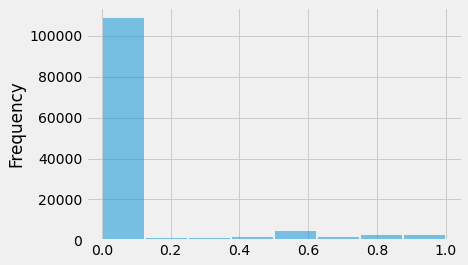

In [ ]:
# show results
print('mean: %.2f' % words_df['subjectivity'].mean())
print('std: %.2f' % words_df['subjectivity'].std(), '\n')

words_df['subjectivity'].plot.hist(bins=8, rwidth=0.95, alpha=0.5)
plt.show()

#### b) Polarity

mean: -0.01
std: 0.15 



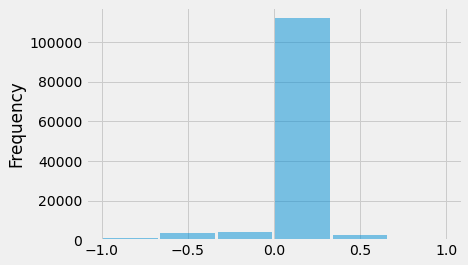

In [ ]:
# show results
print('mean: %.2f' % words_df['polarity'].mean())
print('std: %.2f' % words_df['polarity'].std(), '\n')

words_df['polarity'].plot.hist(bins=6, rwidth=0.95, alpha=0.5)
plt.show()

### 3.4.2 The most frequent positive, negative and neutral words <a name="342-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [19]:
# count word frequencies
word_counts_df = words_df.value_counts().reset_index().rename(columns={0:'counts'})

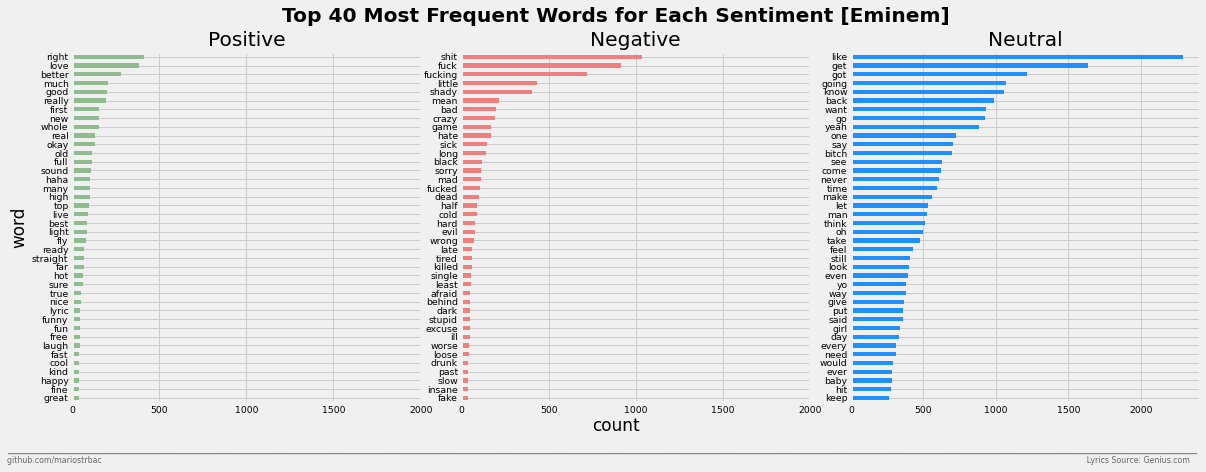

In [24]:
style.use('fivethirtyeight')

# define sentiment colors
POSITIVE_COLOR = 'darkseagreen'
NEGATIVE_COLOR = 'lightcoral'
NEUTRAL_COLOR = 'dodgerblue'

# words per subplot 
NUM_OF_WORDS = 40

fig = plt.figure(figsize=(18,6))

# positive subplot
plt.subplot(131)
positive_word_counts = word_counts_df[word_counts_df['polarity'] > 0][:NUM_OF_WORDS]
positive_word_counts.plot(x='word',
                          y='counts',
                          kind='barh',
                          title='Positive',
                          legend=False,
                          fontsize=9.3,
                          color=POSITIVE_COLOR,
                          xticks=[0, 500, 1000, 1500, 2000],
                          ax=plt.gca()).invert_yaxis()


# negative subplot
plt.subplot(132)
negative_word_counts = word_counts_df[word_counts_df['polarity'] < 0][:NUM_OF_WORDS]
negative_word_counts.plot(x='word',
                          y='counts',
                          kind='barh',
                          title='Negative',
                          xlabel='',
                          legend=False,
                          fontsize=9.3,
                          color=NEGATIVE_COLOR,
                          xticks=[0, 500, 1000, 1500, 2000],
                          ax=plt.gca()).invert_yaxis()


# neutral subplot
plt.subplot(133)
neutral_word_counts = word_counts_df[word_counts_df['polarity'] == 0][:NUM_OF_WORDS]
neutral_word_counts.plot(x='word',
                         y='counts',
                         kind='barh',
                         title='Neutral',
                         xlabel='',
                         legend=False,
                         fontsize=9.3, 
                         color=NEUTRAL_COLOR,
                         ax=plt.gca()).invert_yaxis()

# title
fig.text(0.5, 0.95, 'Top 40 Most Frequent Words for Each Sentiment [Eminem]', ha='center', fontsize='x-large', fontweight=555)

# x-label
fig.text(0.5, 0.004, 'count', ha='center', fontsize=17)

# signature bar
fig.text(x=0.03, y=-0.045, s=str('_'*170).expandtabs(), color='grey')
fig.text(x=0.03, y=-0.07, 
         s=str("github.com/mariostrbac" + "  " * 196 + "  Lyrics Source: Genius.com").expandtabs(),
         fontsize=7.9,
         color='dimgrey')

plt.subplots_adjust(wspace=0.117, hspace=0)
plt.savefig('../reports/figures/vocabulary-analysis/40_most_frequent_words_sentiment_eminem.png', dpi=200, bbox_inches='tight')
plt.show()

### 3.4.3 The most frequent words including sentiment annotation <a name="343-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [25]:
# for colors encoding
COLORS_DICT = {-1: NEGATIVE_COLOR, 0: NEUTRAL_COLOR, 1: POSITIVE_COLOR}

# returns a sentiment color for a given word based on the word's polarity value
get_sentiment_color = lambda polarity: COLORS_DICT[polarity / np.abs(polarity) if polarity !=0 else 0]

# assign a color to each word according to their polarity value
words_sentiment_colors = word_counts_df.polarity.apply(get_sentiment_color)

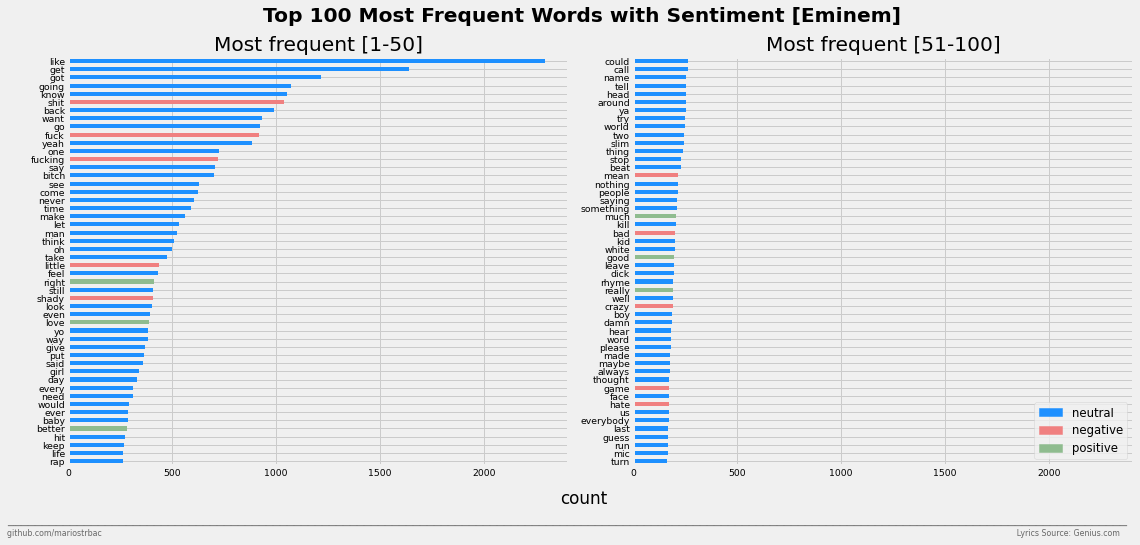

In [28]:
style.use('fivethirtyeight')

# words per subplot
NUM_OF_WORDS = 50

fig, axs = plt.subplots(1, 2, figsize=(17,7), sharex=True)

# left subplot [0-50]
word_counts_df[:NUM_OF_WORDS].plot(x='word',
                                   y='counts',
                                   kind='barh',
                                   title='Most frequent [1-50]',
                                   xlabel='',
                                   fontsize=9.3, 
                                   legend=False,
                                   color=words_sentiment_colors[:NUM_OF_WORDS],
                                   ax=axs[0]).invert_yaxis()

# right subplot [50-100]
word_counts_df[NUM_OF_WORDS:2*NUM_OF_WORDS].plot(x='word',
                                                 y='counts',
                                                 kind='barh',
                                                 title='Most frequent [51-100]',
                                                 xlabel='',
                                                 fontsize=9.3, 
                                                 color=words_sentiment_colors[NUM_OF_WORDS: 2*NUM_OF_WORDS],
                                                 ax=axs[1]).invert_yaxis()
# legend
plt.legend(handles=[Patch(color=NEUTRAL_COLOR, label='neutral'), 
                    Patch(color=NEGATIVE_COLOR, label='negative'), 
                    Patch(color=POSITIVE_COLOR, label='positive')],
           loc=4, 
           fancybox=True, 
           shadow=False, 
           fontsize='small')
# title
fig.text(x=0.5, y=0.95, 
         s='Top 100 Most Frequent Words with Sentiment [Eminem]', ha='center', fontsize='x-large', fontweight=555)

# xlabel
plt.xlabel("count", x=-0.1, y=0.045, labelpad=12)

# signature bar
fig.text(x=0.03, y=-0.045, s=str('_'*160).expandtabs(), color='grey')
fig.text(x=0.03, y=-0.07, 
         s=str("github.com/mariostrbac " + "  "*182 + " Lyrics Source: Genius.com").expandtabs(),
         fontsize=7.9,
         color='dimgrey')

plt.subplots_adjust(wspace=0.13, hspace=0)
plt.savefig('../reports/figures/vocabulary-analysis/100_most_frequent_words_sentiment_eminem.png', dpi=200, bbox_inches='tight')
plt.show()

## 3.5 Profanity analysis <a name="35-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

### 3.5.1 The most common profanity words <a name="351-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

After inspecting the previous graph, the most frequent profanity words are written down and stored for the further analysis.

In [40]:
PROFANITY_WORDS = ['fuck', 'fucking', 'fucked', 'shit', 'bitch', 'dick']

# df object for profanity analysis
profanity_df = data_df.loc[:, ['title', 'featured', 'release_date', 'album_name', 'popularity', 'lyrics']]
# split lyrics into words and clean dash and contraction words
profanity_df['lyrics'] = profanity_df.apply(get_only_eminems_verses, axis=1) \
                                     .apply(split_lyrics_into_words) \
                                     .apply(dash_and_contractions_cleaning)

# filter out profanity words in each song to a separate column 
profanity_df['profanity_words'] = profanity_df['lyrics'].apply(lambda lyrics: [word for word in lyrics if word in PROFANITY_WORDS])

### 3.5.2 The relative frequency of profanity words <a name="352-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

The relative frequency refers to the occurrence rate of profanity words in the corpus and is calculated as follows:

$$ f_\text{profanity}\ (corpus)\ =\text{ ... }\ = \frac{N_\text{profanity words}}{N_\text{all words}}$$

, where *N* is the number of words in the corpus.

In [41]:
# total count of profanity words in the corpus
profanity_count = word_counts_df[(word_counts_df.word=="fuck") | 
                                 (word_counts_df.word=="shit") | 
                                 (word_counts_df.word=="bitch") | 
                                 (word_counts_df.word=="fucking") | 
                                 (word_counts_df.word=="dick") | 
                                 (word_counts_df.word=="fucked")] ["counts"].sum()

print("-the number of profanity words in the corpus:", profanity_count)
print("-the relative frequency:", np.round(profanity_count / len(all_words), 2))

p_ratio = np.round((len(all_words)-profanity_count)/ profanity_count, 2)
print(f"-the ratio of non-profanity words to profanity words is {p_ratio}, i.e. there is a profanity word every {int(p_ratio)} words")

-the number of profanity words in the corpus: 3678
-the relative frequency: 0.03
-the ratio of non-profanity words to profanity words is 32.71, i.e. there is a profanity word every 32 words


### 3.5.3 The average number of profanity words per song  <a name="353-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

#### a) All songs included

mean: 8.86
std: 8.40 



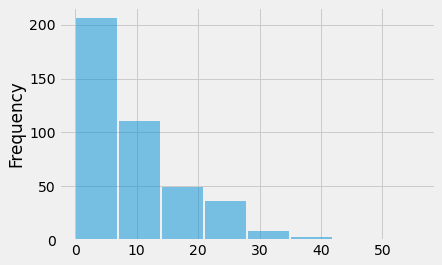

In [44]:
# number of profanity words for each song
profanity_cnt_songs = profanity_df['profanity_words'].apply(lambda words: len(words))

# show results
print('mean: %.2f' % profanity_cnt_songs.mean())
print('std: %.2f' % profanity_cnt_songs.std(), '\n')

profanity_cnt_songs.plot.hist(bins=8, rwidth=0.95, alpha=0.5)
plt.show()

#### b) Only the songs that have "release_date" column

mean: 9.55
std: 8.61 



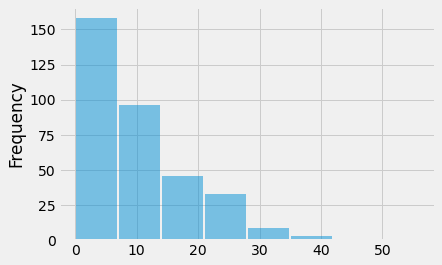

In [45]:
# number of profanity words for each song with release date
profanity_cnt_songs = profanity_df[profanity_df['release_date'].isnull() == False]['profanity_words'].apply(lambda words: len(words))

# show results
print('mean: %.2f' % profanity_cnt_songs.mean())
print('std: %.2f' % profanity_cnt_songs.std(), '\n')

profanity_cnt_songs.plot.hist(bins=8, rwidth=0.95, alpha=0.5)
plt.show()

### 3.5.4 S-word/F-word graph  <a name="354-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

The S-word/F-word graph shows s-word and f-word ratios for each song. Since those are the most frequent profanity words in the corpus, the outliers on the graph can be seen as songs with the most profanity. The relative frequencies are calculated as follows:

$$ f_\text{s-word}\ =\text{ ... }\ = \frac{N_\text{s-words}}{N_\text{all words}}$$ <br>
$$ f_\text{f-word}\ =\text{ ... }\ = \frac{N_\text{f-words}}{N_\text{all words}}$$

, where *N* is the number of words in lyrics. So, for example, if the f-word ratio is 0.10 that means 10% of words in the song are f-words.

In [80]:
# calculate the ratios for each song
profanity_df['f_ratio'] = profanity_df.apply(lambda row: len([word for word in row.profanity_words if word[:4]=='fuck']) / len(row.lyrics), axis=1)
profanity_df['s_ratio'] = profanity_df.apply(lambda row: len([word for word in row.profanity_words if word=='shit']) / len(row.lyrics), axis=1)

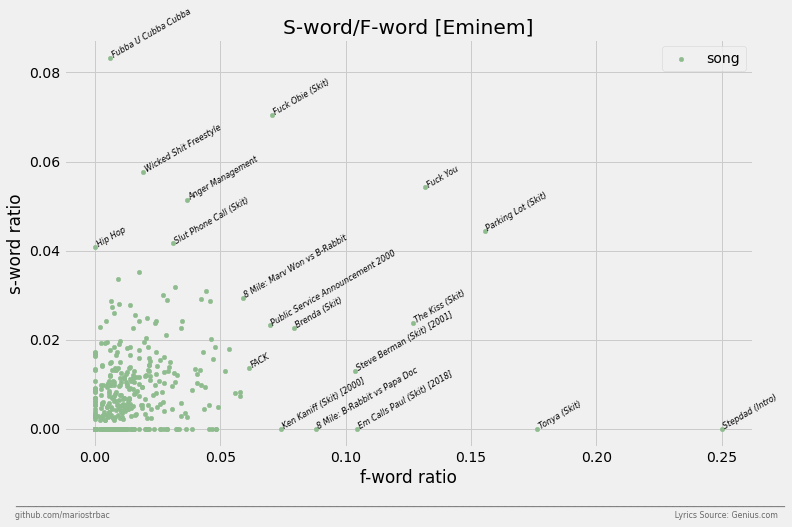

In [167]:
style.use('fivethirtyeight')

# text rotation angle
ROT_ANGL = 30

# plot the graph
profanity_plt = profanity_df.plot(x='f_ratio',
                                  y='s_ratio',
                                  kind='scatter',
                                  figsize=(11,7), 
                                  title='S-word/F-word [Eminem]',
                                  color='darkseagreen') 
# top f-word and s-word ratios
top_f_ratio_df = profanity_df.sort_values(['f_ratio'], ascending=False)[:14][['title', 'f_ratio', 's_ratio']]
top_s_ratio_df = profanity_df.sort_values(['s_ratio'], ascending=False)[:8][['title', 'f_ratio', 's_ratio']]
top_fs_ratio_df = pd.concat([top_f_ratio_df, top_s_ratio_df]).drop_duplicates()

# plot annotations
top_fs_ratio_df.apply(lambda row: profanity_plt.annotate(row.title, 
                                                         (row['f_ratio'], row['s_ratio']),
                                                         fontsize=8, 
                                                         fontstyle='oblique', 
                                                         fontweight='roman',
                                                         rotation=ROT_ANGL),
                                                         axis=1)
# legend
profanity_plt.legend(['song'], loc=1)

# x-label, y-label
profanity_plt.set_xlabel('f-word ratio')
profanity_plt.set_ylabel('s-word ratio')

# signature bar
profanity_plt.text(x=-0.032, y=-0.017, s=str('_' * 110).expandtabs(), color='grey')
profanity_plt.text(x=-0.032, y=-0.02,
                   s=str("github.com/mariostrbac " + "  " * 112 + " Lyrics Source: Genius.com").expandtabs(),
                   fontsize=7.9,
                   color='dimgrey')

plt.savefig('../reports/figures/vocabulary-analysis/profanity_ratios_graf.png', dpi=240, bbox_inches='tight')
plt.show()

### 3.5.5 Profanity words through the years  <a name="355-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

The following graph shows the profanity ratio for each song, along with their release date. The profanity words considered for the ratio are the top five most frequent profanity words in the corpus, from [Section 3.5.1.](#351-bullet). The relative frequency of profanity words in lyrics is calculated as follows:

$$ f_\text{profanity}\ =\text{ ... }\ = \frac{N_\text{profanity words}}{N_\text{all words}}$$

, where *N* is the number of words in lyrics. So, for example, if the profanity ratio is 0.20 that means 20% of words in the song are profanity words.

In [76]:
# calculate the profanity ratio for each song
profanity_df['profanity_ratio'] = profanity_df.apply(lambda row: len(row.profanity_words) / len(row.lyrics), axis=1)

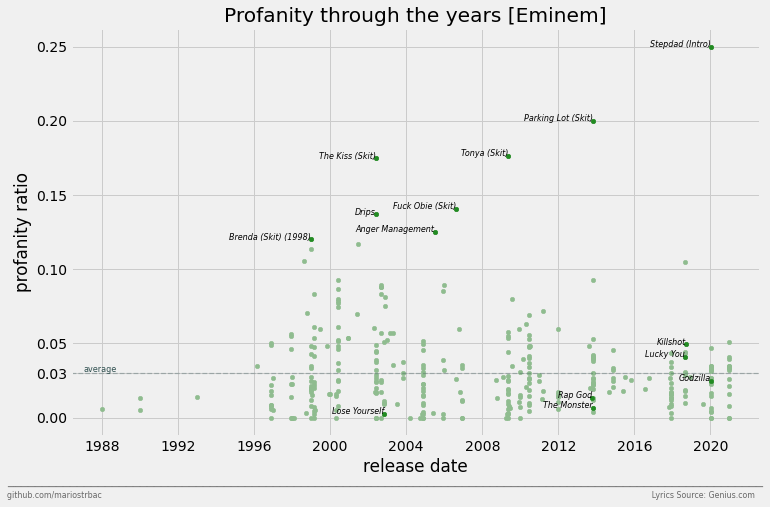

In [133]:
style.use('fivethirtyeight')

N_TOP = 8
N_TOP_POP = 6

# only songs with release date information
profanity_rdate_df = profanity_df[profanity_df.release_date.isnull()==False]

# plot the graph
profanity_plt = profanity_rdate_df.plot(x='release_date',
                                        y='profanity_ratio',
                                        kind='scatter',
                                        figsize=(11, 7), 
                                        title='Profanity through the years [Eminem]',
                                        color='darkseagreen')

# highlight songs with highest profanity ratios
profanity_rdate_df.sort_values('profanity_ratio', ascending=False)[:N_TOP] \
                  .plot(x='release_date',
                        y='profanity_ratio',
                        kind='scatter',
                        figsize=(11, 7), 
                        color='forestgreen',
                        ax=profanity_plt)

# highlight the most popular songs in the corpus                        
profanity_rdate_df.sort_values('popularity')[:N_TOP_POP] \
                  .plot(x='release_date',
                        y='profanity_ratio',
                        kind='scatter',
                        figsize=(11, 7), 
                        color='forestgreen',
                        ax=profanity_plt)

# annotate songs with highest profanity ratios
profanity_rdate_df.sort_values('profanity_ratio', ascending=False)[:N_TOP] \
                  .apply(lambda row: profanity_plt.annotate(row.title, 
                                                            (row.release_date, row.profanity_ratio),
                                                            ha='right',
                                                            fontsize=8, 
                                                            fontstyle='oblique', 
                                                            fontweight='roman',
                                                            rotation=0), 
                                                            axis=1)
# annotate the most popular songs in the corpus
profanity_rdate_df.sort_values('popularity')[:N_TOP_POP] \
                  .apply(lambda row: profanity_plt.annotate(row.title, 
                                                            (row.release_date, row.profanity_ratio),
                                                            ha='right',
                                                            fontsize=8, 
                                                            fontstyle='oblique', 
                                                            fontweight='roman',
                                                            rotation=0), 
                                                            axis=1)
# plot the average line
profanity_plt.axhline(y=np.round(profanity_rdate_df['profanity_ratio'].mean(), 2), 
                      ls='--', 
                      color='darkslategrey', 
                      linewidth=1.3, 
                      alpha=0.3)

# the average line annotation
profanity_plt.text(x='1987', 
                   y=np.round(profanity_rdate_df['profanity_ratio'].mean(),2) + 0.001, 
                   s='average', 
                   fontsize=8, 
                   color='darkslategrey')

# change number of ticks on y-axis
profanity_plt.set_yticks([0.0, np.round(profanity_rdate_df['profanity_ratio'].mean(),2), 0.05, 0.1, 0.15, 0.2, 0.25])               

# labels
profanity_plt.set_xlabel('release date')
profanity_plt.set_ylabel('profanity ratio')

# signature bar
profanity_plt.text(x='1983', y=-0.045, s=str('_' * 108).expandtabs(), color='grey')
profanity_plt.text(x='1983', y=-0.054,
                   s=str("github.com/mariostrbac" + " " * 220 + "Lyrics Source: Genius.com").expandtabs(),
                   fontsize=7.9,
                   color='dimgrey')

plt.savefig('../reports/figures/vocabulary-analysis/songs_profanity_through_years_eminem.png', dpi=240, bbox_inches='tight')
plt.show()

## 3.6 Word count by the first letter (no stopwords)  <a name="36-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

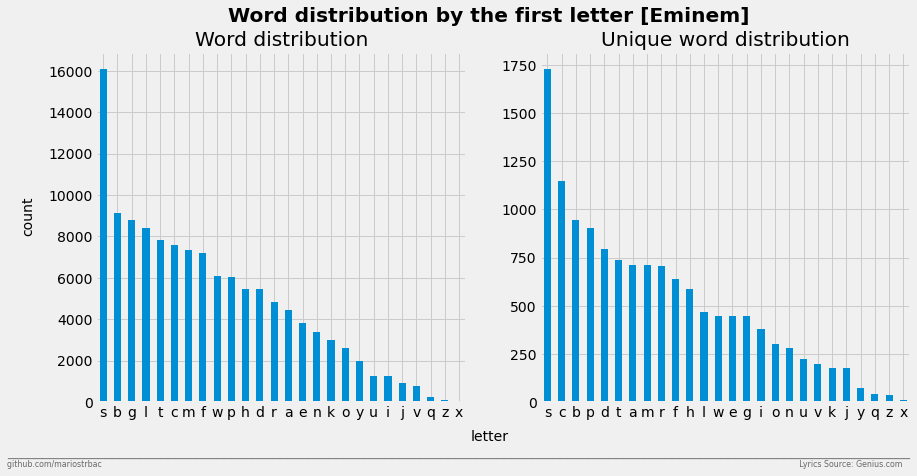

In [30]:
style.use('fivethirtyeight')

# init an empty dict object
word_distribution = defaultdict(list)

# sort words by their first letter
for word in words_df.word.values:
    word_distribution[word[0]].append(word)


fig, ax = plt.subplots(1,2, figsize=(13,6))

# plot the word distribution (with duplicates)
pd.DataFrame(word_distribution.items(), columns=['letter', 'words']) \
               .apply(lambda row: pd.Series([row.letter, len(row.words)], index=['letter', 'word counts']), axis=1) \
               .sort_values('word counts', ascending=False) \
               .plot(x='letter', 
                     kind='bar',
                     title='Word distribution',
                     legend=False,
                     xlabel='',
                     rot=0,
                     ax=ax[0]) 

# plot the unique word distribution (no duplicates)
pd.DataFrame(word_distribution.items(), columns=['letter', 'words']) \
              .apply(lambda row: pd.Series([row.letter, len(set(row.words))], index=['letter', 'word counts']), axis=1) \
              .sort_values('word counts', ascending=False) \
              .plot(x='letter', 
                    kind='bar',
                    title='Unique word distribution',
                    legend=False,
                    xlabel='',
                    rot=0,
                    ax=ax[1]) 

# title
fig.text(x=0.5, y=0.95, s='Word distribution by the first letter [Eminem]', ha='center', fontsize='x-large', fontweight=555)

# labels
fig.text(0.5, -0.02, 'letter', ha='center')
fig.text(0.0, 0.5, 'count', va='center', rotation='vertical')

# signature bar
fig.text(x=-0.015, y=-0.055, s=str('_' * 129).expandtabs(), color='grey')
fig.text(x=-0.015, y=-0.08,
         s=str("github.com/mariostrbac" + "  " * 139 + " Lyrics Source: Genius.com").expandtabs(),
         fontsize=7.9,
         color='dimgrey')

plt.savefig('../reports/figures/vocabulary-analysis/word_distribution_first_letter.png', dpi=240, bbox_inches='tight')
plt.show()

---

# 4. Lyrics sentiment analysis  <a name="4-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [168]:
sentiment_df = data_df.loc[:, ['title', 'featured', 'release_date', 'album_id', 'popularity', 'lyrics']]

# split lyrics into words and clean contractions and dash words
sentiment_df['lyrics'] = sentiment_df.apply(get_only_eminems_verses, axis=1) \
                                     .apply(split_lyrics_into_words) \
                                     .apply(dash_and_contractions_cleaning)
# calculate the average subjectivity for each songs                                    
sentiment_df['subjectivity']= sentiment_df.lyrics \
                                          .apply(lambda lyrics: np.mean([TextBlob(word).sentiment.subjectivity for word in lyrics]))
# calculate the average polarity for each song                                          
sentiment_df['polarity'] = sentiment_df.lyrics \
                                       .apply(lambda lyrics: np.mean([TextBlob(word).sentiment.polarity for word in lyrics]))

## 4.1 The subjectivity/polarity of lyrics  <a name="41-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

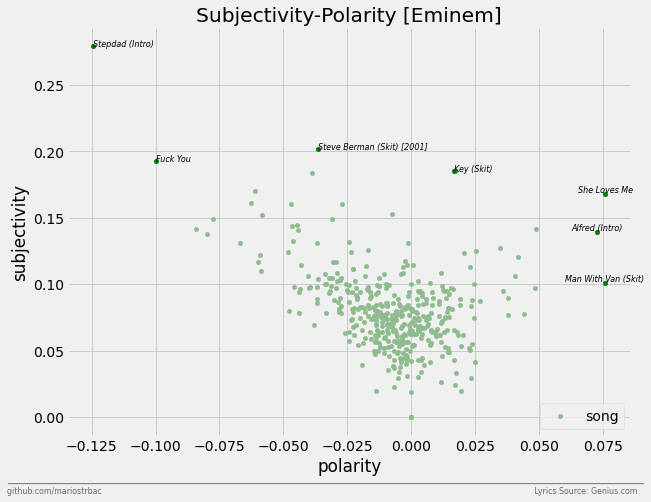

In [ ]:
style.use('fivethirtyeight')

# top subjectivity examples
N_TOP_SUB = 4
# top polarity examples
N_TOP_POL = 3

# subjectivity-polarity graph
pol_sub_plt = sentiment_df.plot(x='polarity',
                                y='subjectivity',
                                kind='scatter',
                                figsize=(9,7),
                                title='Subjectivity-Polarity [Eminem]',
                                color='darkseagreen')

# highlight songs with highest subjectivity
sentiment_df.sort_values('subjectivity', ascending=False) \
            .iloc[:N_TOP_SUB] \
            .plot(x='polarity', y='subjectivity', kind='scatter', color='green', ax=pol_sub_plt)

# annotate songs with highest subjectivity
sentiment_df.sort_values('subjectivity', ascending=False)[:N_TOP_SUB] \
            .apply(lambda row: pol_sub_plt.annotate(row.title, (row.polarity, row.subjectivity),
                                                    fontsize=8, 
                                                    fontstyle='oblique', 
                                                    fontweight='roman'), axis=1)

# highlight songs with highest polarity
sentiment_df.sort_values('polarity', ascending=False) \
            .iloc[:N_TOP_POL] \
            .plot(x='polarity', y='subjectivity', kind='scatter', color='green', ax=pol_sub_plt)

# annotate songs with highest polarity
sentiment_df.sort_values('polarity', ascending=False)[:N_TOP_POL] \
            .apply(lambda row: pol_sub_plt.annotate(row.title, (row.polarity, row.subjectivity),
                                                    fontsize=8, 
                                                    fontstyle='oblique', 
                                                    fontweight='roman',
                                                    ha='center',
                                                    va='bottom'), axis=1)
# legend
pol_sub_plt.legend(['song'], loc=4)

# signature bar
pol_sub_plt.text(x=-0.158, y=-0.048, s=str('_'* 91).expandtabs(), color='grey')
pol_sub_plt.text(x=-0.158, y=-0.057, 
                 s=str("github.com/mariostrbac " + "  " * 86 + "Lyrics Source: Genius.com").expandtabs(),
                 fontsize=7.9, 
                 color='dimgrey')

plt.savefig('../reports/figures/sentiment-analysis/songs_subjectivity_polarity_eminem.png', dpi=240, bbox_inches='tight')
plt.show()

## 4.2 The polarity of songs through the years  <a name="42-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

In [169]:
# filter out the rows with no "release date" info
sentiment_rdate_df = sentiment_df[sentiment_df.release_date.isnull() == False]

# compute coefficients for the approximation of the best-fit line
degree = 2
polarity_df = sentiment_rdate_df[['release_date', 'polarity']].groupby('release_date').mean().reset_index()
mean_polarity_per_year = polarity_df.polarity.values
years = polarity_df.release_date.apply(lambda x: x.year).values
a, b, c = np.polyfit(years, mean_polarity_per_year, degree)

# quadratic function that approximates a best-fit line (trendline) for given coefficients
quadratic_poly = lambda x_df: a * np.square(x_df.release_date.year) + b * x_df.release_date.year + c

# best-fit line points
polarity_df['fit_points'] = polarity_df.apply(quadratic_poly, axis=1)

# show restuls
polarity_df.head()

,release_date,polarity,fit_points
0,1988-01-01,-0.003256,0.000472
1,1990-01-01,0.007623,-0.001941
2,1993-01-01,0.006466,-0.004984
3,1996-02-17,-0.000833,-0.007337
4,1996-11-12,0.003346,-0.007337


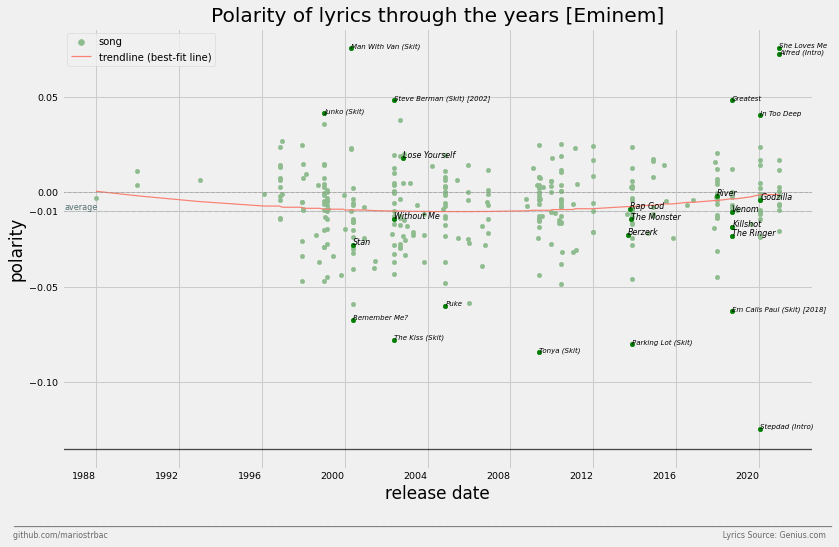

In [172]:
style.use('fivethirtyeight')

# 1. STEP
# polarity-release_date plot 
polarity_plt = sentiment_rdate_df.plot(x='release_date',
                                       y='polarity',
                                       kind='scatter',
                                       figsize=(12,9),
                                       title="Polarity of lyrics through the years [Eminem]",
                                       legend=False,
                                       fontsize=9.5,
                                       color='darkseagreen')

# trendline (best-fit line) 
polarity_df.plot(x='release_date',
                 y='fit_points',
                 kind='line',
                 legend=False,
                 linewidth=1.2, 
                 color='salmon',
                 ax=polarity_plt)

# 2. STEP
# highlight/annotate most negative, positive and popular songs on the graph
N_NEGATIVE = N_POSITIVE = 7
N_MOST_POPULAR = 13
most_negative_songs = sentiment_rdate_df[['title', 'popularity', 'release_date', 'polarity']] \
                                .sort_values('polarity', ascending=False)[:N_NEGATIVE]
most_positive_songs = sentiment_rdate_df[['title', 'popularity', 'release_date', 'polarity']] \
                                .sort_values('polarity', ascending=True)[:N_POSITIVE]
most_popular_songs = sentiment_rdate_df[['title', 'popularity', 'release_date', 'polarity']] \
                                .sort_values('popularity')[:N_MOST_POPULAR]
# merge the dateframes into one dateframe
top_songs_df = pd.concat([most_negative_songs, most_positive_songs, most_popular_songs])

# preprocess the data before plotting
top_songs_df = top_songs_df[top_songs_df['title'].isin(['Lucky You', 'Not Alike']) == False]
top_songs_df['fontsize'] = top_songs_df['popularity'].apply(lambda popularity: 8 if popularity <= N_MOST_POPULAR 
                                                                                 else 7)
# highlight the top songs on the graph with green dots
top_songs_df.plot(x='release_date',
                  y='polarity',
                  kind='scatter',
                  legend=False,
                  color='green',
                  ax=polarity_plt)

# annotate the highlighted points
top_songs_df.apply(lambda row: polarity_plt.annotate(row.title, (row.release_date, row.polarity), 
                                                     fontsize=row.fontsize, 
                                                     fontstyle='oblique', 
                                                     fontweight='roman'), 
                                                     axis=1)
# 3. STEP
# plot horizontal lines at the bottom and in the middle of the graph
polarity_plt.axhline(y = -0.135, color = 'black', linewidth = 1.3, alpha = .7)
polarity_plt.axhline(y = 0, color = 'grey', linewidth = 1, alpha = .4, linestyle='--')

# plot horizontal line for the average polarity value
avg_polarity = np.round(sentiment_rdate_df['polarity'].mean(), 2)
polarity_plt.axhline(y=avg_polarity, ls='--', color='darkslategrey', linewidth=1.3, alpha=0.1)
polarity_plt.text(x='1986.7', y=avg_polarity + 0.0006, s='average', fontsize=8, color='darkslategrey', alpha=0.8)

# set a tick for the average value
polarity_plt.set_yticks([-0.10, -0.05, np.round(sentiment_rdate_df['polarity'].mean(),2), 0.0, 0.05])

# x-label
polarity_plt.set_xlabel('release date')

# add a custom legend to the graph
polarity_plt.legend(handles = [plt.scatter([], [], lw=0.6, color='darkseagreen'),
                               plt.plot([], lw=1.2, color='salmon', ls="-")[0]], 
                    labels=['song', 'trendline (best-fit line)'], 
                    fontsize=10, 
                    loc=2)
# signature bar
polarity_plt.text(x='1984', y=-0.175, s=str('_'*117).expandtabs(), color='grey')
polarity_plt.text(x='1984', y=-0.182,
                  s=str("github.com/mariostrbac " + " " * 243 + "  Lyrics Source: Genius.com").expandtabs(),
                  fontsize=7.9,
                  color='dimgrey')

plt.savefig('../reports/figures/sentiment-analysis/songs_polarity_through_years_eminem.png', dpi=240, bbox_inches='tight')
plt.show()

---

# 5. Topic modeling  <a name="5-bullet"></a> <a href="#0-bullet"> <sup><sup><sup>^</sup></sup></sup></a>

`// TODO`